In [1]:
import csv
import os
import numpy as np
import h5py
import skimage.io

from glob import glob
img_path_list = glob("CK+48\\*") + glob("fer\\all\\*")
print(img_path_list)

['CK+48\\angry', 'CK+48\\disgust', 'CK+48\\fear', 'CK+48\\happy', 'CK+48\\neutral', 'CK+48\\sad', 'CK+48\\surprise', 'fer\\all\\angry', 'fer\\all\\disgust', 'fer\\all\\fear', 'fer\\all\\happy', 'fer\\all\\neutral', 'fer\\all\\sad', 'fer\\all\\surprise']


In [2]:
# Creat the list to store the data and label information
# train_pixel = []
# train_label = []
# test_pixel = []
# test_label = []
data_pixel = {}
data_label = {}
datapath = os.path.join('data','all_data.npy')
if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

In [3]:
import random
import torch

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)

In [4]:
for i, img_path in enumerate(img_path_list):
    tag = img_path.split("\\")[-1]
    data_pixel.setdefault(tag, [])
    data_label.setdefault(tag, [])
    files = os.listdir(img_path)
    files.sort()
    length = len(files)
    for j, filename in enumerate(files):
        I = skimage.io.imread(os.path.join(img_path,filename))
        data_pixel[tag].append(I.tolist())
        data_label[tag].append(i%7)
        # if j<length*0.8:
        #     train_pixel.append(I.tolist())
        #     train_label.append(i)
        # else:
        #     test_pixel.append(I.tolist())
        #     test_label.append(i)

In [5]:
print(len(data_pixel))
print(len(data_label))

7
7


In [6]:
from PIL import Image
import numpy as np
import h5py
import torch.utils.data as data


class CustomDataset(data.Dataset):
    """
    Args:
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
    """

    def __init__(self, data_pixel, data_label, fold=1, transform=None):
        self.transform = transform
        self.fold = fold  # the k-fold cross validation
        self.data_pixel = data_pixel
        self.data_label = data_label


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = np.array(self.data_pixel[index]), self.data_label[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis=2)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data_pixel)


In [7]:
from sklearn.model_selection import StratifiedKFold
from torch.autograd import Variable
import utils
from torch import nn, optim
from models import ResNet18, VGG
import transforms
import torch

use_cuda = torch.cuda.is_available()
opt = {
    "model": "ResNet101",
    "dataset": "all",
    "fold": 10,
    "train_bs": 64,
    "test_bs": 256,
    "val_bs":256,
    "lr": 0.01,
    "resume": None,
}


best_Test_acc = 0  # best PrivateTest accuracy
best_Test_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 20  # 50
learning_rate_decay_every = 1  # 5
learning_rate_decay_rate = 0.8  # 0.9

cut_size = 44
total_epoch = 60

path = os.path.join(opt["dataset"] + '_' + opt["model"], str(opt["fold"]))

# Data
transform_train = transforms.Compose([
    transforms.RandomCrop(cut_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

In [8]:
from sklearn.model_selection import train_test_split, KFold
train_data = []
val_data = []
test_data = []
train_labels = []
val_labels = []
test_labels = []
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3407)
for tag in data_pixel.keys():
    # print("************************************************************************************************")
    X = data_pixel[tag]
    y = data_label[tag]
    # print("X.len= ", len(X))
    for train_val_index, test_index in skf.split(X, y):
        train_val_X, test_X = [X[i] for i in train_val_index], [X[i] for i in test_index]
        train_val_y, test_y = [y[i] for i in train_val_index], [y[i] for i in test_index]
        # print("train_val_X.len= ", len(train_val_X))
        # print("test_X.len= ", len(test_X))

        train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=3407)
        # print("train_X.len= ", len(train_X))
        # print("val_X.len= ", len(val_X))

        # # print(len(train_X))
    for i in train_X:
        train_data.append(i)
    for i in train_y:
        train_labels.append(i)
    for i in val_X:
        val_data.append(i)
    for i in val_y:
        val_labels.append(i)
    for i in test_X:
        test_data.append(i)
    for i in test_y:
        test_labels.append(i)

print(len(train_data))
print(len(val_data))
print(len(test_data))

26544
6640
3684


In [9]:
# def flat(data):
#     return [i for sublist in data for i in sublist]

In [10]:
# train_data = flat(train_data)
# train_labels = flat(train_labels)
# val_data = flat(val_data)
# val_labels = flat(val_labels)
# test_data = flat(test_data)
# test_labels = flat(test_labels)
#
# print(len(train_data))
# print(len(val_data))
# print(len(test_data))

TypeError: 'int' object is not iterable

In [34]:

# for train_index, test_index in skf.split(data_pixel, data_label):
#     # print(train_index, test_index)
#     # for i in train_index:
#     #     print(i)
#     train_data, test_data = [data_pixel[i] for i in train_index], [data_pixel[i] for i in test_index]
#     train_labels, test_labels = [data_label[i] for i in train_index], [data_label[i] for i in test_index]

TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
print(len(train_data))
print(len(test_data))

26544
3684


In [10]:
trainset = CustomDataset(fold=opt["fold"], transform=transform_train, data_pixel=train_data, data_label=train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=opt["train_bs"], shuffle=True)
testset = CustomDataset(fold=opt["fold"], transform=transform_test, data_pixel=test_data, data_label=test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=opt["test_bs"], shuffle=False)
valset = CustomDataset(fold=opt["fold"], transform=transform_test, data_pixel=val_data, data_label=val_labels)
valloader = torch.utils.data.DataLoader(valset, batch_size=opt["val_bs"], shuffle=False)


In [11]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([64, 3, 44, 44])
torch.Size([64])


E:\projects\Facial-Expression-Recognition\transforms\functional.py:63: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


In [12]:
from tqdm import tqdm

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = opt["lr"] * decay_factor
        utils.set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = opt["lr"]
    print('learning_rate: %s' % str(current_lr))

    for inputs, targets in tqdm(trainloader):
        # print(batch_idx, (inputs, targets))
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # print(inputs, targets)
        optimizer.zero_grad()
        # print(optimizer)
        inputs, targets = Variable(inputs), Variable(targets)
        # print(inputs, targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        utils.clip_gradient(optimizer, 0.1)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))



    Train_acc = 100. * correct / total



In [13]:
def test(epoch, all_predicted, all_targets):
    global Test_acc
    global best_Test_acc
    global best_Test_acc_epoch

    net.eval()
    PrivateTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops

        loss = criterion(outputs_avg, targets)
        PrivateTest_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # utils.progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
        #                    % (PrivateTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        if batch_idx == 0:
            temp_all_predicted = predicted
            temp_all_targets = targets
        else:
            temp_all_predicted = torch.cat((temp_all_predicted, predicted), 0)
            temp_all_targets = torch.cat((temp_all_targets, targets), 0)

    # Save checkpoint.
    Test_acc = 100. * correct / total

    if Test_acc > best_Test_acc:
        print('Saving..')
        print("best_Test_acc: %0.3f" % Test_acc)
        state = {'net': net.state_dict() if use_cuda else net,
                 'best_Test_acc': Test_acc,
                 'best_Test_acc_epoch': epoch,
                 }
        if not os.path.isdir(opt["dataset"] + '_' + opt["model"]):
            os.mkdir(opt["dataset"] + '_' + opt["model"])
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path, 'resnet101_SelfAttention_Test_model.t7'))
        best_Test_acc = Test_acc
        best_Test_acc_epoch = epoch
        all_predicted = temp_all_predicted
        all_targets = temp_all_targets
        # print("test", all_predicted, all_targets)

    return all_predicted, all_targets


In [14]:
def validate():
    net.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            bs, ncrops, c, h, w = np.shape(inputs)
            inputs = inputs.view(-1, c, h, w)
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
            loss = criterion(outputs_avg, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs_avg.data, 1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets.data).cpu().sum()
            utils.progress_bar(batch_idx, len(valloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)\n'
                               % (val_loss / (batch_idx + 1), 100. * val_correct / val_total, val_correct, val_total))
    val_acc = 100. * val_correct / val_total
    return val_loss, val_acc

In [24]:
# Model
# if opt["model"] == 'VGG19':
#     net = VGG('VGG19')
# elif opt["model"] == 'ResNet18':
#     net = ResNet18()


# ResNet101

In [25]:
from models import resnet101
net = resnet101.resnet101(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)

==> Building model..


In [26]:
all_predicted = None
all_targets = None

for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)


Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.99it/s]
15it [00:03,  4.56it/s]


Saving..
best_Test_acc: 21.960

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.72it/s]
15it [00:03,  4.72it/s]


Saving..
best_Test_acc: 34.446

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.72it/s]
15it [00:03,  4.75it/s]


Saving..
best_Test_acc: 46.118

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.87it/s]
15it [00:03,  4.76it/s]


Saving..
best_Test_acc: 50.706

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.89it/s]
15it [00:03,  4.65it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.09it/s]
15it [00:03,  4.77it/s]


Saving..
best_Test_acc: 51.412

Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.05it/s]
15it [00:03,  4.75it/s]


Saving..
best_Test_acc: 52.090

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.93it/s]
15it [00:03,  4.80it/s]


Saving..
best_Test_acc: 54.207

Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.00it/s]
15it [00:03,  4.76it/s]



Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.07it/s]
15it [00:03,  4.76it/s]


Saving..
best_Test_acc: 55.157

Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.07it/s]
15it [00:03,  4.74it/s]


Saving..
best_Test_acc: 58.035

Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.06it/s]
15it [00:03,  4.77it/s]


Saving..
best_Test_acc: 59.093

Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 37.05it/s]
15it [00:03,  4.75it/s]



Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.98it/s]
15it [00:03,  4.76it/s]


Saving..
best_Test_acc: 60.098

Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.86it/s]
15it [00:03,  4.62it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.58it/s]
15it [00:03,  4.68it/s]



Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.60it/s]
15it [00:03,  4.73it/s]



Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.61it/s]
15it [00:03,  4.73it/s]


Saving..
best_Test_acc: 61.835

Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.65it/s]
15it [00:03,  4.74it/s]


Saving..
best_Test_acc: 62.215

Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.51it/s]
15it [00:03,  4.70it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:11<00:00, 36.71it/s]
15it [00:03,  4.71it/s]



Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:11<00:00, 36.76it/s]
15it [00:03,  4.70it/s]


Saving..
best_Test_acc: 62.676

Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:11<00:00, 36.96it/s]
15it [00:03,  4.64it/s]


Saving..
best_Test_acc: 62.839

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:11<00:00, 36.62it/s]
15it [00:03,  4.71it/s]



Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:11<00:00, 36.93it/s]
15it [00:03,  4.72it/s]


Saving..
best_Test_acc: 65.337

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:11<00:00, 36.87it/s]
15it [00:03,  4.72it/s]


Saving..
best_Test_acc: 65.499

Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:11<00:00, 36.71it/s]
15it [00:03,  4.72it/s]



Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:11<00:00, 36.98it/s]
15it [00:03,  4.72it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:11<00:00, 37.07it/s]
15it [00:03,  4.68it/s]


Saving..
best_Test_acc: 65.744

Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:11<00:00, 37.14it/s]
15it [00:03,  4.71it/s]


Saving..
best_Test_acc: 66.124

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:11<00:00, 37.04it/s]
15it [00:03,  4.72it/s]


Saving..
best_Test_acc: 66.205

Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:11<00:00, 37.02it/s]
15it [00:03,  4.65it/s]


Saving..
best_Test_acc: 66.395

Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:11<00:00, 37.06it/s]
15it [00:03,  4.72it/s]


Saving..
best_Test_acc: 66.450

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:11<00:00, 36.97it/s]
15it [00:03,  4.74it/s]



Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:11<00:00, 37.14it/s]
15it [00:03,  4.69it/s]


Saving..
best_Test_acc: 67.155

Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:11<00:00, 37.08it/s]
15it [00:03,  4.74it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:11<00:00, 37.07it/s]
15it [00:03,  4.71it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:11<00:00, 37.18it/s]
15it [00:03,  4.75it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:11<00:00, 37.18it/s]
15it [00:03,  4.73it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:11<00:00, 36.93it/s]
15it [00:03,  4.71it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:11<00:00, 36.90it/s]
15it [00:03,  4.67it/s]


Saving..
best_Test_acc: 67.182

Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:11<00:00, 36.67it/s]
15it [00:03,  4.71it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:11<00:00, 36.92it/s]
15it [00:03,  4.73it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:11<00:00, 36.16it/s]
15it [00:03,  4.62it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:11<00:00, 36.17it/s]
15it [00:03,  4.70it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:11<00:00, 36.86it/s]
15it [00:03,  4.75it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:11<00:00, 36.97it/s]
15it [00:03,  4.73it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:11<00:00, 37.27it/s]
15it [00:03,  4.73it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:11<00:00, 37.32it/s]
15it [00:03,  4.72it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:11<00:00, 37.34it/s]
15it [00:03,  4.74it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:11<00:00, 37.33it/s]
15it [00:03,  4.74it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:11<00:00, 37.27it/s]
15it [00:03,  4.74it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:11<00:00, 37.28it/s]
15it [00:03,  4.73it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:11<00:00, 37.23it/s]
15it [00:03,  4.74it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:11<00:00, 37.30it/s]
15it [00:03,  4.77it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:11<00:00, 37.21it/s]
15it [00:03,  4.74it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:11<00:00, 37.25it/s]
15it [00:03,  4.76it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:11<00:00, 37.31it/s]
15it [00:03,  4.72it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:11<00:00, 37.28it/s]
15it [00:03,  4.76it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:11<00:00, 37.22it/s]
15it [00:03,  4.75it/s]

best_Test_acc: 67.182
best_Test_acc_epoch: 40


In [27]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.65 0.   0.07 0.04 0.12 0.09 0.02]
 [0.22 0.67 0.   0.04 0.01 0.03 0.03]
 [0.13 0.   0.47 0.03 0.13 0.18 0.07]
 [0.02 0.   0.01 0.86 0.06 0.03 0.01]
 [0.08 0.   0.03 0.07 0.64 0.16 0.02]
 [0.1  0.   0.1  0.06 0.19 0.54 0.01]
 [0.03 0.   0.08 0.05 0.04 0.01 0.79]]


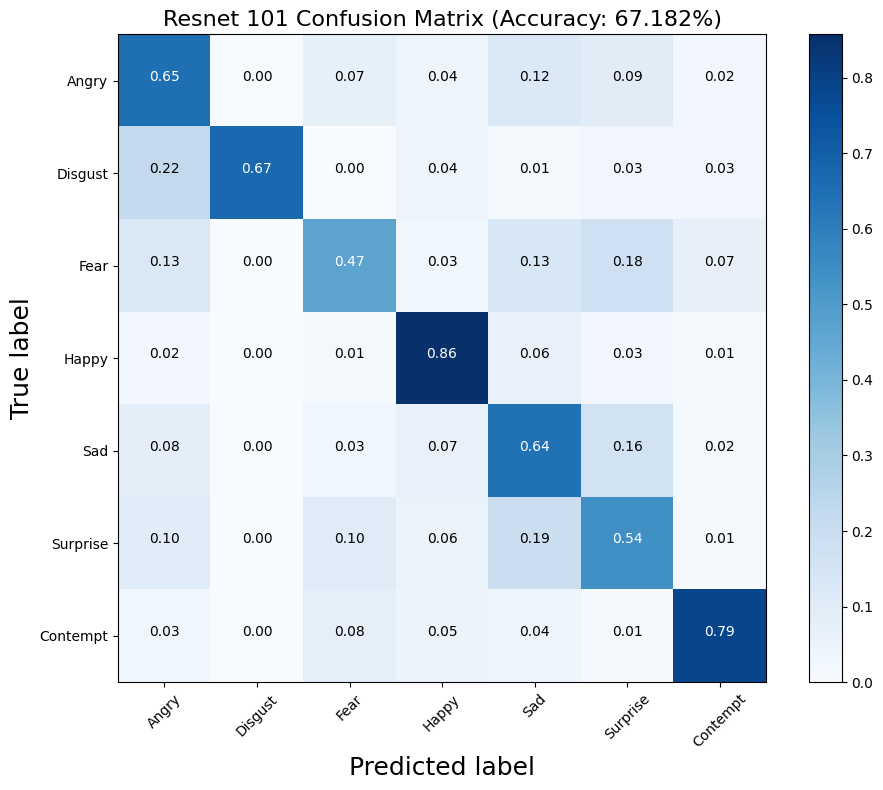

In [28]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='Resnet 101 Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet Confusion Matrix.png'))
plt.close()

# Resnet101 + SE Attention

In [15]:
from models import resnet101_SEAttention
net = resnet101_SEAttention.resnet101_SE_attention(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)



==> Building model..


In [16]:
all_predicted = None
all_targets = None
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)



Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:17<00:00, 23.97it/s]
15it [00:03,  4.46it/s]


Saving..
best_Test_acc: 38.925

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.16it/s]
15it [00:03,  4.66it/s]



Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.84it/s]
15it [00:03,  4.61it/s]


Saving..
best_Test_acc: 46.661

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.69it/s]
15it [00:03,  4.63it/s]


Saving..
best_Test_acc: 53.393

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.31it/s]
15it [00:03,  4.63it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.37it/s]
15it [00:03,  4.68it/s]



Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.34it/s]
15it [00:03,  4.64it/s]


Saving..
best_Test_acc: 57.139

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.34it/s]
15it [00:03,  4.69it/s]


Saving..
best_Test_acc: 58.008

Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.94it/s]
15it [00:03,  4.70it/s]


Saving..
best_Test_acc: 59.012

Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.25it/s]
15it [00:03,  4.67it/s]



Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.28it/s]
15it [00:03,  4.69it/s]



Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.29it/s]
15it [00:03,  4.61it/s]



Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.48it/s]
15it [00:03,  4.66it/s]


Saving..
best_Test_acc: 61.455

Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.49it/s]
15it [00:03,  4.66it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.60it/s]
15it [00:03,  4.71it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.60it/s]
15it [00:03,  4.69it/s]



Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.66it/s]
15it [00:03,  4.71it/s]


Saving..
best_Test_acc: 61.944

Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 27.85it/s]
15it [00:03,  4.59it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.15it/s]
15it [00:03,  4.64it/s]



Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:14<00:00, 28.27it/s]
15it [00:03,  4.67it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:15<00:00, 27.49it/s]
15it [00:03,  4.64it/s]


Saving..
best_Test_acc: 62.052

Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:14<00:00, 28.40it/s]
15it [00:03,  4.66it/s]


Saving..
best_Test_acc: 63.436

Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:14<00:00, 28.34it/s]
15it [00:03,  4.56it/s]


Saving..
best_Test_acc: 64.549

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:14<00:00, 28.24it/s]
15it [00:03,  4.64it/s]


Saving..
best_Test_acc: 65.065

Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:14<00:00, 28.08it/s]
15it [00:03,  4.67it/s]


Saving..
best_Test_acc: 66.042

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:14<00:00, 28.17it/s]
15it [00:03,  4.64it/s]



Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:14<00:00, 28.04it/s]
15it [00:03,  4.66it/s]



Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:14<00:00, 28.27it/s]
15it [00:03,  4.63it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:14<00:00, 28.23it/s]
15it [00:03,  4.70it/s]



Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:14<00:00, 28.34it/s]
15it [00:03,  4.61it/s]


Saving..
best_Test_acc: 66.748

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:14<00:00, 28.14it/s]
15it [00:03,  4.62it/s]


Saving..
best_Test_acc: 66.775

Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:14<00:00, 28.22it/s]
15it [00:03,  4.67it/s]



Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:14<00:00, 28.36it/s]
15it [00:03,  4.56it/s]



Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:14<00:00, 28.18it/s]
15it [00:03,  4.62it/s]


Saving..
best_Test_acc: 67.291

Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:14<00:00, 28.22it/s]
15it [00:03,  4.60it/s]



Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:14<00:00, 28.03it/s]
15it [00:03,  4.65it/s]


Saving..
best_Test_acc: 67.508

Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:14<00:00, 28.13it/s]
15it [00:03,  4.62it/s]



Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:14<00:00, 28.15it/s]
15it [00:03,  4.62it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:14<00:00, 28.23it/s]
15it [00:03,  4.61it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:14<00:00, 28.09it/s]
15it [00:03,  4.63it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:14<00:00, 28.02it/s]
15it [00:03,  4.60it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:14<00:00, 28.15it/s]
15it [00:03,  4.62it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:14<00:00, 27.92it/s]
15it [00:03,  4.58it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:14<00:00, 28.04it/s]
15it [00:03,  4.65it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:14<00:00, 27.93it/s]
15it [00:03,  4.63it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:14<00:00, 28.00it/s]
15it [00:03,  4.65it/s]



Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:14<00:00, 27.72it/s]
15it [00:03,  4.63it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:14<00:00, 28.21it/s]
15it [00:03,  4.63it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:14<00:00, 27.71it/s]
15it [00:03,  4.50it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:14<00:00, 27.95it/s]
15it [00:03,  4.50it/s]



Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:14<00:00, 27.89it/s]
15it [00:03,  4.59it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:14<00:00, 28.04it/s]
15it [00:03,  4.59it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:14<00:00, 27.84it/s]
15it [00:03,  4.60it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:14<00:00, 28.14it/s]
15it [00:03,  4.62it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:14<00:00, 28.10it/s]
15it [00:03,  4.65it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:14<00:00, 28.30it/s]
15it [00:03,  4.60it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:14<00:00, 28.17it/s]
15it [00:03,  4.60it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:14<00:00, 28.31it/s]
15it [00:03,  4.67it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:14<00:00, 28.21it/s]
15it [00:03,  4.65it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:14<00:00, 28.21it/s]
15it [00:03,  4.59it/s]

best_Test_acc: 67.508
best_Test_acc_epoch: 35


In [14]:
import itertools
from matplotlib import pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Normalized confusion matrix
[[0.62 0.   0.08 0.04 0.11 0.12 0.02]
 [0.21 0.69 0.01 0.   0.01 0.07 0.  ]
 [0.12 0.   0.48 0.03 0.11 0.19 0.07]
 [0.02 0.   0.01 0.86 0.05 0.04 0.01]
 [0.08 0.   0.04 0.07 0.62 0.18 0.02]
 [0.11 0.   0.1  0.05 0.15 0.57 0.01]
 [0.02 0.   0.08 0.04 0.04 0.02 0.8 ]]


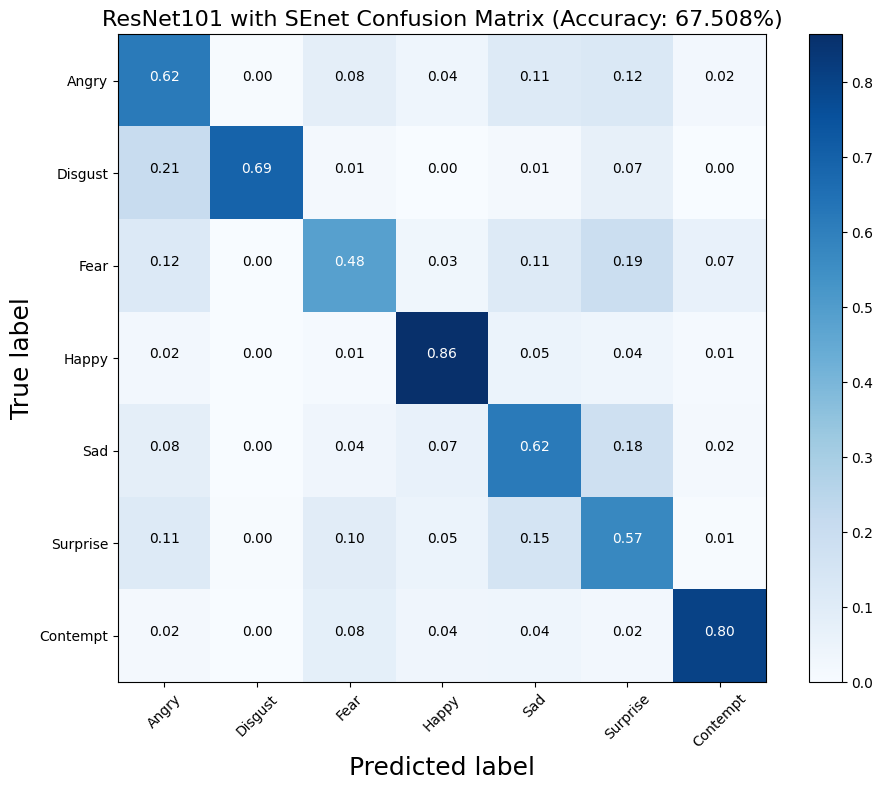

In [18]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with SEnet Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with SEnet Confusion Matrix.png'))
plt.close()

# 自注意力机制(transformer encode部分)

In [15]:
from models import resnet101_SelfAttention

net = resnet101_SelfAttention.resnet101_self_attention(num_classes=7)

if opt["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(path), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'])
    best_Test_acc = checkpoint['best_Test_acc']
    best_Test_acc_epoch = checkpoint['best_Test_acc_epoch']
    start_epoch = best_Test_acc_epoch + 1
else:
    print('==> Building model..')

if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=opt["lr"], momentum=0.9, weight_decay=5e-4)


==> Building model..


In [16]:
all_predicted = None
all_targets = None
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    all_predicted, all_targets = test(epoch, all_predicted, all_targets)
    # print(all_predicted, all_targets)

print("best_Test_acc: %0.3f" % best_Test_acc)
print("best_Test_acc_epoch: %d" % best_Test_acc_epoch)


Epoch: 0
learning_rate: 0.01


100%|██████████| 415/415 [00:22<00:00, 18.25it/s]
15it [00:03,  3.97it/s]


Saving..
best_Test_acc: 39.549

Epoch: 1
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.07it/s]
15it [00:03,  4.27it/s]


Saving..
best_Test_acc: 41.341

Epoch: 2
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.14it/s]
15it [00:03,  4.27it/s]


Saving..
best_Test_acc: 48.887

Epoch: 3
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.11it/s]
15it [00:03,  4.25it/s]


Saving..
best_Test_acc: 49.077

Epoch: 4
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.62it/s]
15it [00:03,  4.24it/s]



Epoch: 5
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.73it/s]
15it [00:03,  4.22it/s]


Saving..
best_Test_acc: 54.343

Epoch: 6
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.69it/s]
15it [00:03,  4.24it/s]


Saving..
best_Test_acc: 55.239

Epoch: 7
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.54it/s]
15it [00:03,  4.26it/s]



Epoch: 8
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.69it/s]
15it [00:03,  4.23it/s]


Saving..
best_Test_acc: 57.980

Epoch: 9
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.71it/s]
15it [00:03,  4.22it/s]


Saving..
best_Test_acc: 58.306

Epoch: 10
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 21.89it/s]
15it [00:03,  4.27it/s]



Epoch: 11
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.18it/s]
15it [00:03,  4.30it/s]



Epoch: 12
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.21it/s]
15it [00:03,  4.30it/s]


Saving..
best_Test_acc: 59.853

Epoch: 13
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.10it/s]
15it [00:03,  4.28it/s]



Epoch: 14
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.27it/s]
15it [00:03,  4.25it/s]



Epoch: 15
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.17it/s]
15it [00:03,  4.27it/s]


Saving..
best_Test_acc: 60.858

Epoch: 16
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.16it/s]
15it [00:03,  4.31it/s]



Epoch: 17
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.31it/s]
15it [00:03,  4.31it/s]



Epoch: 18
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.25it/s]
15it [00:03,  4.27it/s]


Saving..
best_Test_acc: 61.156

Epoch: 19
learning_rate: 0.01


100%|██████████| 415/415 [00:18<00:00, 22.25it/s]
15it [00:03,  4.30it/s]



Epoch: 20
learning_rate: 0.01


100%|██████████| 415/415 [00:19<00:00, 21.75it/s]
15it [00:03,  4.31it/s]


Saving..
best_Test_acc: 61.591

Epoch: 21
learning_rate: 0.008


100%|██████████| 415/415 [00:18<00:00, 22.26it/s]
15it [00:03,  4.26it/s]



Epoch: 22
learning_rate: 0.006400000000000001


100%|██████████| 415/415 [00:19<00:00, 21.79it/s]
15it [00:03,  4.16it/s]


Saving..
best_Test_acc: 64.061

Epoch: 23
learning_rate: 0.005120000000000001


100%|██████████| 415/415 [00:19<00:00, 21.68it/s]
15it [00:03,  4.24it/s]



Epoch: 24
learning_rate: 0.004096000000000001


100%|██████████| 415/415 [00:18<00:00, 22.03it/s]
15it [00:03,  4.25it/s]


Saving..
best_Test_acc: 64.549

Epoch: 25
learning_rate: 0.0032768000000000007


100%|██████████| 415/415 [00:18<00:00, 21.88it/s]
15it [00:03,  4.21it/s]


Saving..
best_Test_acc: 65.744

Epoch: 26
learning_rate: 0.002621440000000001


100%|██████████| 415/415 [00:18<00:00, 22.01it/s]
15it [00:03,  4.25it/s]



Epoch: 27
learning_rate: 0.002097152000000001


100%|██████████| 415/415 [00:18<00:00, 21.94it/s]
15it [00:03,  4.26it/s]



Epoch: 28
learning_rate: 0.001677721600000001


100%|██████████| 415/415 [00:19<00:00, 21.79it/s]
15it [00:03,  4.21it/s]



Epoch: 29
learning_rate: 0.0013421772800000006


100%|██████████| 415/415 [00:18<00:00, 21.93it/s]
15it [00:03,  4.17it/s]


Saving..
best_Test_acc: 66.612

Epoch: 30
learning_rate: 0.0010737418240000006


100%|██████████| 415/415 [00:18<00:00, 21.93it/s]
15it [00:03,  4.24it/s]



Epoch: 31
learning_rate: 0.0008589934592000006


100%|██████████| 415/415 [00:18<00:00, 21.91it/s]
15it [00:03,  4.25it/s]


Saving..
best_Test_acc: 66.775

Epoch: 32
learning_rate: 0.0006871947673600004


100%|██████████| 415/415 [00:19<00:00, 21.83it/s]
15it [00:03,  4.23it/s]


Saving..
best_Test_acc: 67.074

Epoch: 33
learning_rate: 0.0005497558138880004


100%|██████████| 415/415 [00:18<00:00, 22.00it/s]
15it [00:03,  4.24it/s]


Saving..
best_Test_acc: 67.454

Epoch: 34
learning_rate: 0.00043980465111040037


100%|██████████| 415/415 [00:18<00:00, 22.00it/s]
15it [00:03,  4.25it/s]



Epoch: 35
learning_rate: 0.0003518437208883203


100%|██████████| 415/415 [00:18<00:00, 22.05it/s]
15it [00:03,  4.25it/s]



Epoch: 36
learning_rate: 0.00028147497671065624


100%|██████████| 415/415 [00:18<00:00, 21.93it/s]
15it [00:03,  4.25it/s]


Saving..
best_Test_acc: 67.834

Epoch: 37
learning_rate: 0.00022517998136852504


100%|██████████| 415/415 [00:18<00:00, 22.01it/s]
15it [00:03,  4.24it/s]



Epoch: 38
learning_rate: 0.00018014398509482002


100%|██████████| 415/415 [00:18<00:00, 22.09it/s]
15it [00:03,  4.22it/s]



Epoch: 39
learning_rate: 0.00014411518807585602


100%|██████████| 415/415 [00:18<00:00, 22.10it/s]
15it [00:03,  4.27it/s]



Epoch: 40
learning_rate: 0.00011529215046068484


100%|██████████| 415/415 [00:19<00:00, 21.40it/s]
15it [00:03,  4.23it/s]



Epoch: 41
learning_rate: 9.223372036854788e-05


100%|██████████| 415/415 [00:18<00:00, 21.90it/s]
15it [00:03,  4.21it/s]



Epoch: 42
learning_rate: 7.37869762948383e-05


100%|██████████| 415/415 [00:19<00:00, 21.55it/s]
15it [00:03,  4.26it/s]



Epoch: 43
learning_rate: 5.902958103587064e-05


100%|██████████| 415/415 [00:18<00:00, 21.85it/s]
15it [00:03,  4.21it/s]



Epoch: 44
learning_rate: 4.722366482869652e-05


100%|██████████| 415/415 [00:18<00:00, 21.88it/s]
15it [00:03,  4.21it/s]



Epoch: 45
learning_rate: 3.777893186295722e-05


100%|██████████| 415/415 [00:18<00:00, 21.94it/s]
15it [00:03,  4.27it/s]


Saving..
best_Test_acc: 67.970

Epoch: 46
learning_rate: 3.0223145490365776e-05


100%|██████████| 415/415 [00:19<00:00, 21.82it/s]
15it [00:03,  4.22it/s]



Epoch: 47
learning_rate: 2.417851639229262e-05


100%|██████████| 415/415 [00:19<00:00, 21.12it/s]
15it [00:03,  4.20it/s]



Epoch: 48
learning_rate: 1.9342813113834096e-05


100%|██████████| 415/415 [00:18<00:00, 21.91it/s]
15it [00:03,  4.22it/s]



Epoch: 49
learning_rate: 1.547425049106728e-05


100%|██████████| 415/415 [00:19<00:00, 21.81it/s]
15it [00:03,  4.23it/s]


Saving..
best_Test_acc: 68.187

Epoch: 50
learning_rate: 1.2379400392853824e-05


100%|██████████| 415/415 [00:18<00:00, 21.87it/s]
15it [00:03,  4.22it/s]



Epoch: 51
learning_rate: 9.903520314283058e-06


100%|██████████| 415/415 [00:19<00:00, 21.77it/s]
15it [00:03,  4.20it/s]



Epoch: 52
learning_rate: 7.922816251426448e-06


100%|██████████| 415/415 [00:18<00:00, 21.96it/s]
15it [00:03,  4.18it/s]



Epoch: 53
learning_rate: 6.338253001141158e-06


100%|██████████| 415/415 [00:19<00:00, 21.82it/s]
15it [00:03,  4.22it/s]



Epoch: 54
learning_rate: 5.0706024009129275e-06


100%|██████████| 415/415 [00:19<00:00, 21.73it/s]
15it [00:03,  4.28it/s]



Epoch: 55
learning_rate: 4.056481920730342e-06


100%|██████████| 415/415 [00:18<00:00, 21.85it/s]
15it [00:03,  4.22it/s]



Epoch: 56
learning_rate: 3.2451855365842735e-06


100%|██████████| 415/415 [00:18<00:00, 21.98it/s]
15it [00:03,  4.26it/s]



Epoch: 57
learning_rate: 2.5961484292674196e-06


100%|██████████| 415/415 [00:18<00:00, 22.09it/s]
15it [00:03,  4.21it/s]



Epoch: 58
learning_rate: 2.0769187434139356e-06


100%|██████████| 415/415 [00:18<00:00, 21.99it/s]
15it [00:03,  4.24it/s]



Epoch: 59
learning_rate: 1.6615349947311485e-06


100%|██████████| 415/415 [00:18<00:00, 21.91it/s]
15it [00:03,  4.26it/s]

best_Test_acc: 68.187
best_Test_acc_epoch: 49


Normalized confusion matrix
[[0.61 0.01 0.09 0.04 0.11 0.11 0.02]
 [0.18 0.67 0.07 0.01 0.01 0.03 0.03]
 [0.09 0.   0.52 0.03 0.11 0.18 0.06]
 [0.02 0.   0.02 0.87 0.05 0.03 0.01]
 [0.08 0.   0.06 0.07 0.62 0.16 0.02]
 [0.08 0.   0.13 0.05 0.14 0.59 0.01]
 [0.02 0.   0.08 0.04 0.04 0.01 0.79]]


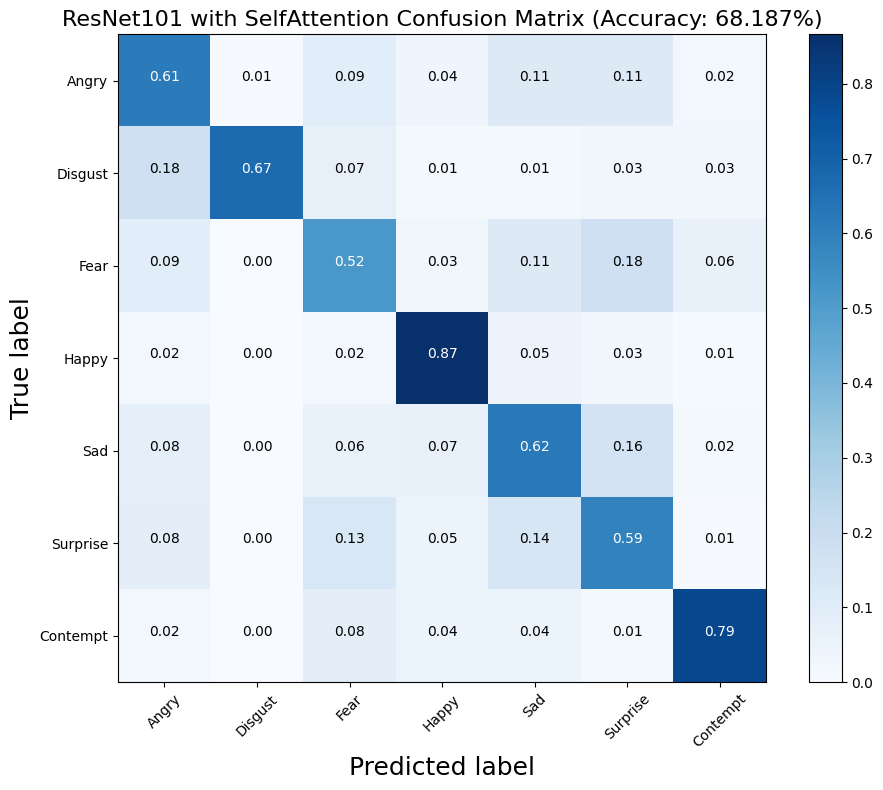

In [17]:
from sklearn.metrics import confusion_matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Contempt']

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title='ResNet101 with SelfAttention Confusion Matrix (Accuracy: %0.3f%%)' % best_Test_acc)
plt.show()
plt.savefig(os.path.join(opt["dataset"] + '_' + opt["model"], 'ResNet101 with SelfAttention Confusion Matrix.png'))
plt.close()